<h1 style="font-family: Verdana; font-size: 28px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #AED6F1; color: black;"><center><br>Project: Pleural Effusion Detection</center>
<center><br>Prediction</center></h1>

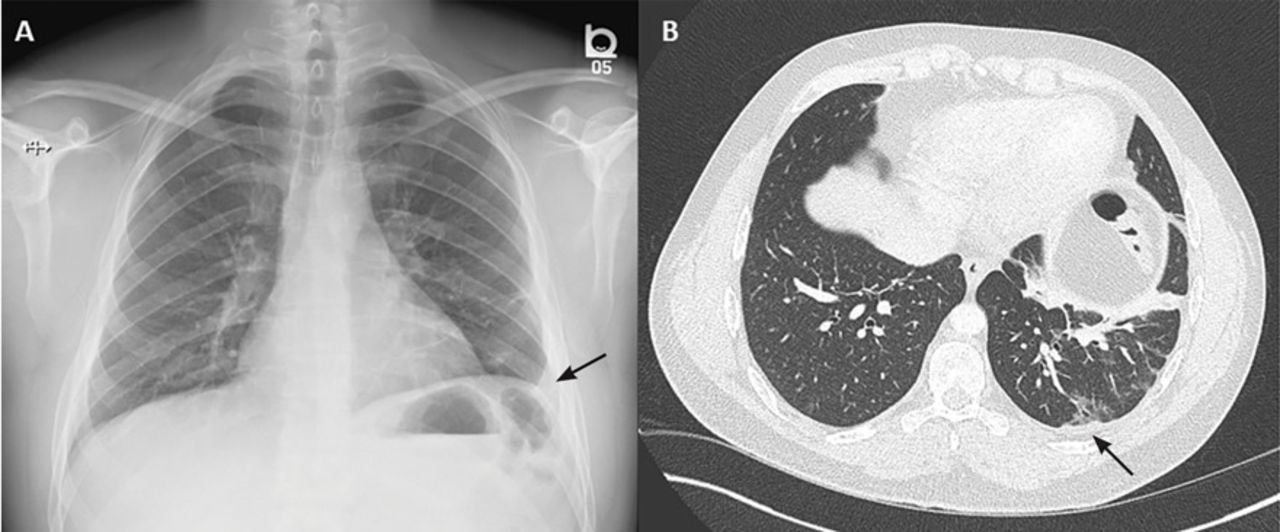

<p id="toc"></p>
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #AED6F1; color: black;" role="tab" aria-controls="home"><center><br>OVERVIEW</center></h1>

- Pleural effusion is an unusual amount of fluid around the lung.

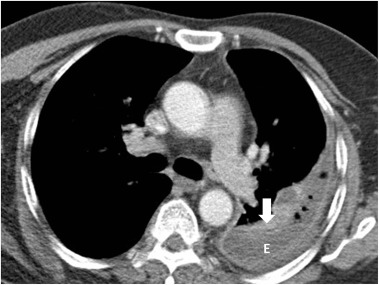

- Pleural effusions can be investigating with magnetic resonance methods (MRI). On the image above you can see the slice image of lungs using MRI. On this slice pleural effusion looks like grey-solid area (E) inside MRI-transparent healthy part of lungs.  

- Based on the MRI images of lungs and masks of pleural effusions we will try to train segmentational neural network to detect this condition 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#" data-toc-modified-id="-1"></a></span></li><li><span><a href="#Data-description" data-toc-modified-id="Data-description-2"><br>Data description</a></span></li><li><span><a href="#" data-toc-modified-id="-3"></a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4"><br>Evaluation</a></span></li><li><span><a href="#" data-toc-modified-id="-5"></a></span></li><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-6"><br>Import modules</a></span></li><li><span><a href="#" data-toc-modified-id="-7"></a></span></li><li><span><a href="#Auxilary-functions-and-classes" data-toc-modified-id="Auxilary-functions-and-classes-8"><br>Auxilary functions and classes</a></span><ul class="toc-item"><li><span><a href="#Loading" data-toc-modified-id="Loading-8.1">Loading</a></span></li></ul></li><li><span><a href="#" data-toc-modified-id="-9"></a></span></li><li><span><a href="#Configuration" data-toc-modified-id="Configuration-10"><br>Configuration</a></span></li><li><span><a href="#" data-toc-modified-id="-11"></a></span></li><li><span><a href="#Create-datasets" data-toc-modified-id="Create-datasets-12"><br>Create datasets</a></span></li><li><span><a href="#" data-toc-modified-id="-13"></a></span></li><li><span><a href="#Load-model" data-toc-modified-id="Load-model-14"><br>Load model</a></span></li><li><span><a href="#" data-toc-modified-id="-15"></a></span></li><li><span><a href="#Predict" data-toc-modified-id="Predict-16"><br>Predict</a></span></li></ul></div>

## 
<p id="toc"></p>
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #AED6F1; color: black;" role="tab" aria-controls="home"><left><br>Data description</left></h2> 

- 1087 one-channel images of MRI scans


- 1087 binary masks for every image indicating pleural effusion  

## 
<p id="toc"></p>
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #AED6F1; color: black;" role="tab" aria-controls="home"><left><br>Evaluation</left></h2> 

For evaluation of predicted mask quality we will use Dice coefficient

The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth.

Dice coefficient is 2 times The area of Overlap divided by the total number of pixels in both the images

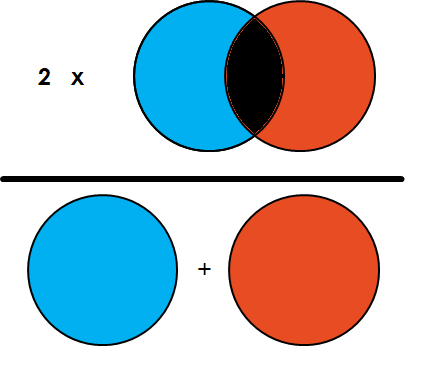


Formula:
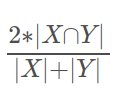

## 

<p id="toc"></p>
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #AED6F1; color: black;" role="tab" aria-controls="home"><left><br>Import modules</left></h2> 

In [5]:
import numpy as np
from time import time
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import torch
import os
import segmentation_models_pytorch as smp

import SimpleITK as sitk
import nibabel as nib
from pathlib import Path
import re
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt
import csv

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset
from torchvision import transforms as T

import torch
import torch.nn.functional as F
import torch.nn as nn
import segmentation_models_pytorch as smp


/home/sergey/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 

<p id="toc"></p>
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #AED6F1; color: black;" role="tab" aria-controls="home"><left><br>Auxilary functions and classes</left></h2> 

### Loading

- Load images from .dcm files

In [6]:
class ImageDataset(Dataset):
    def __init__(self, dir_input, test_size, is_valid=None, normalization=None):
        """
        Initialize images and masks datasets
        :param dir_input: directory with input data
        :param test_size: size of validation dataset
        :param is_valid: defines validation or training set
        :param normalization: normalization to be applied to input images
        """

        # Read images
        self.images = np.load(os.path.join(dir_input, 'images.npz'))

        # Read masks
        self.masks = np.load(os.path.join(dir_input, 'masks.npz'))

        # Read meta-file
        self.meta = pd.read_csv(os.path.join(dir_input,
                                             'meta_file.csv'), sep='\t')

        # Split data into train and validation sets if necessary
        if is_valid:
            idx_train, idx_val, _, _ = train_test_split(self.meta['index'].values,
                                                        self.meta['Effusion'].values,
                                                        test_size=test_size,
                                                        random_state=42)
            if is_valid == True:
                self.meta = self.meta.iloc[idx_val]
            else:
                self.meta = self.meta.iloc[idx_train]

        if normalization:
            self.normalization = T.Normalize(std=443, mean=-720)

    def __getitem__(self, idx):
        """
        Get item from dataset according to index from meta-file
        :param idx: index
        """
        index = 'arr_' + str(self.meta.iloc[idx]['index'])

        mask = T.ToTensor()(self.masks[index]).type(torch.float)
        image = T.ToTensor()(self.images[index]).type(torch.float)

        if self.normalization:
            image = self.normalization(image)

        return image, mask

    def __len__(self):
        """
        Get length of dataset
        """
        return len(self.meta)


In [160]:
def dice_coefficient(mask1, mask2):
    """
    Calculate DICE coefficient between masks in batch
    :param mask1: predicted mask
    :param mask2: ground truth mask
    :return: DICE coefficient
    """

    # Calculate  summary area for each masks
    sum1 = mask1.sum()
    sum2 = mask2.sum()

    # Calculate intersection
    intersection = (mask1 * mask2).sum()

    #  Calculate mean dice coefficient (set value to 1 if both masks are empty)
    coefficient = (2 * intersection / (sum1 + sum2)).nan_to_num(1.).mean().item()

    return  coefficient



In [164]:

def show_predictions(image, mask, pred_mask):
    
    mask = torch.squeeze(mask[0])
    pred_mask = torch.squeeze(pred_mask[0])
    image = torch.squeeze(image[0])

    dice = dice_coefficient(mask, pred_mask)
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))

    ax[0].imshow(image, cmap='gist_yarg')
    ax[0].set_title('Input image\n\n\n\n\n\n', fontsize=25)

    ax[1].imshow(image, cmap='gist_yarg') 
    ax[1].imshow(mask, cmap='cool', alpha=0.9*(mask>0))   
    ax[1].set_title('Input image with\n\nTrue mask - purple\n\n\n\n', fontsize=25)

    ax[2].imshow(image, cmap='gist_yarg')
    ax[2].imshow(mask, cmap='cool', alpha=0.9*(mask>0))   
    ax[2].imshow(pred_mask, cmap='winter', alpha=0.9*(pred_mask>0)) 
    ax[2].set_title(f'Input image with\n\nTrue mask - purple\n\nPredicted mask - green\n\nDICE coef: {dice:.2f} ', fontsize=25)

    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()

    plt.tight_layout()

## 

<p id="toc"></p>
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #AED6F1; color: black;" role="tab" aria-controls="home"><left><br>Configuration</left></h2> 

In [14]:
config = {'dataset': 
          {'dir_images': '../data/raw/images/', 
           'dir_masks': '../data/raw/masks/', 
           'dir_processed': '../data/processed/', 
           'image_height': 512, 
           'image_width': 512}, 
          
          'model': {'architecture': 'UNet', 
                    'dir_output': '../output/'}, 
          
          'train': {'test_size': 0.2, 
                    'batch_size': 8, 
                    'device': 'cuda', 
                    'learning_rate': 0.0001, 
                    'beta1': 0.9, 'beta2': 0.999, 
                    'num_epochs': 100, 
                    'decay_rate': 1}, 
          
          'evaluate': {'batch_size': 1, 
                       'device': 'cuda', 
                       'threshold': 0.5}}


## 

<p id="toc"></p>
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #AED6F1; color: black;" role="tab" aria-controls="home"><left><br>Create datasets</left></h2> 

In [10]:
# Create validation dataset
valid_dataset = ImageDataset(dir_input=config['dataset']['dir_processed'],
                             test_size=config['train']['test_size'],
                             is_valid=True,
                             normalization=True)

# Create dataloader for validation dataset
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=config['evaluate']['batch_size'],
                              shuffle=False)

## 

<p id="toc"></p>
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #AED6F1; color: black;" role="tab" aria-controls="home"><left><br>Load model</left></h2> 

In [11]:
net = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [15]:
net.load_state_dict(torch.load(os.path.join(config['model']['dir_output'], 'model_state.ckpt')))

<All keys matched successfully>

## 

<p id="toc"></p>
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #AED6F1; color: black;" role="tab" aria-controls="home"><left><br>Predict</left></h2> 

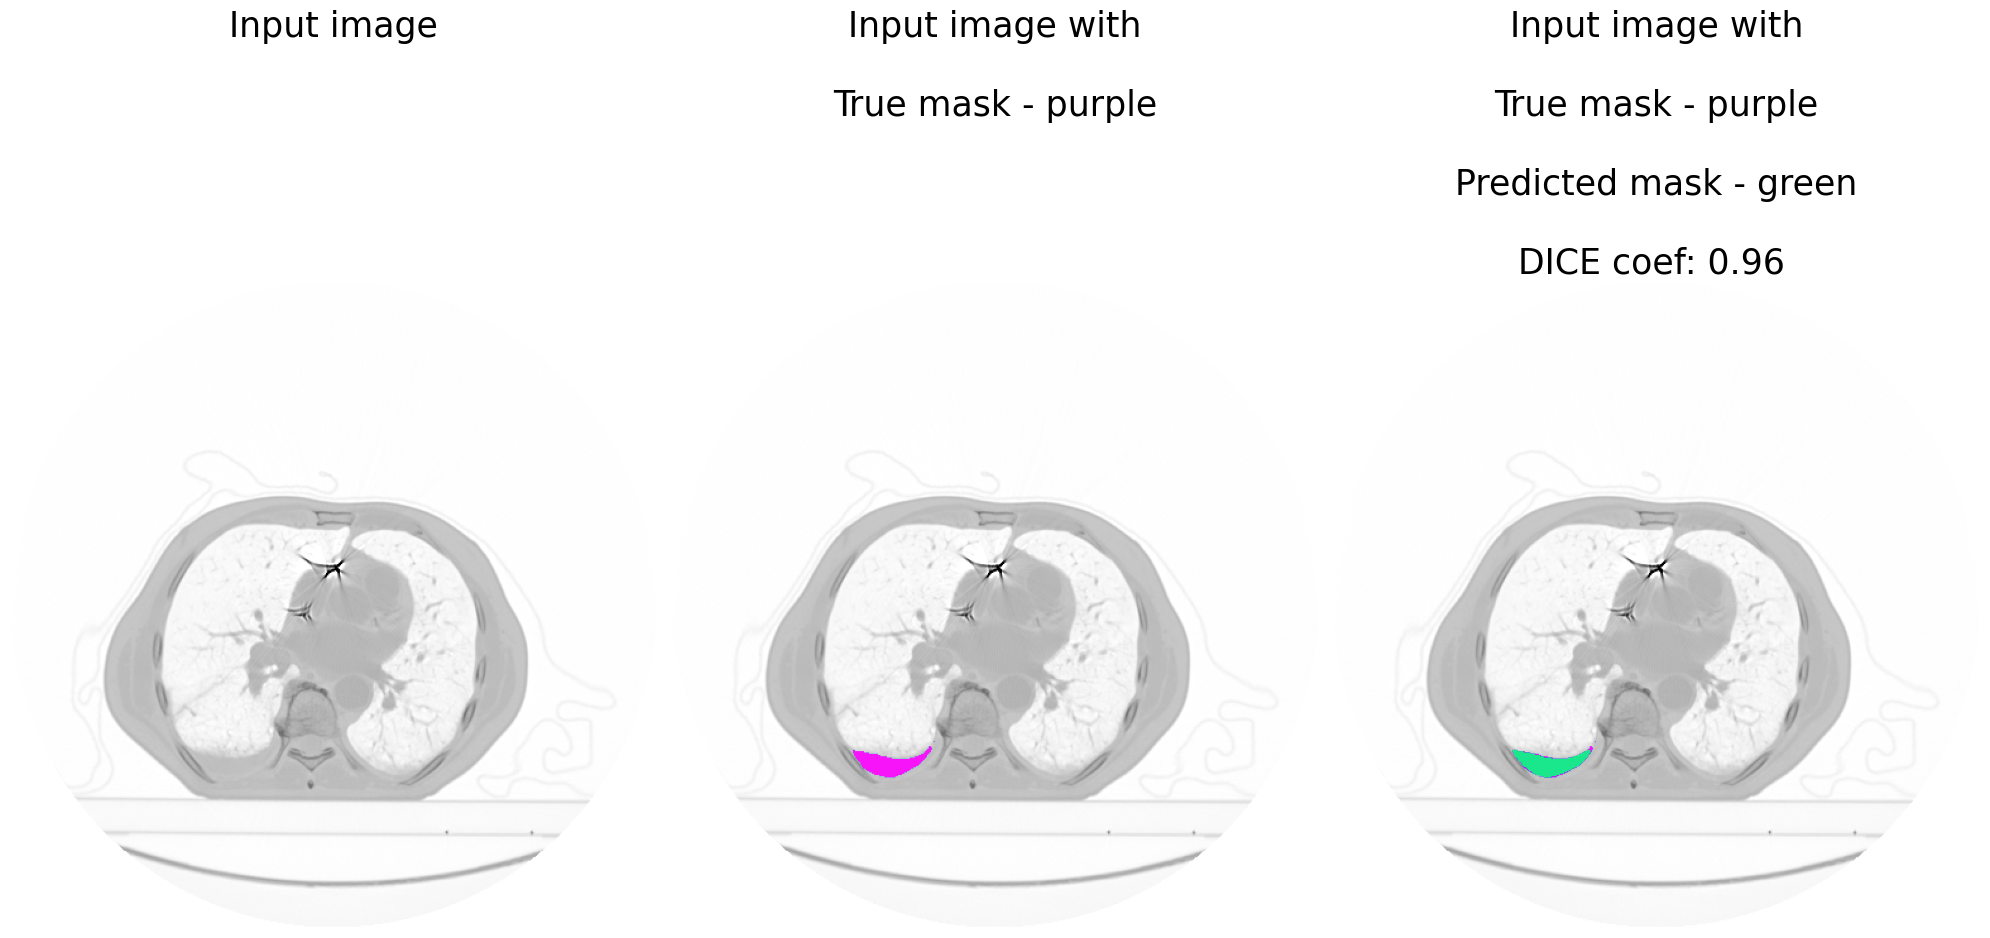

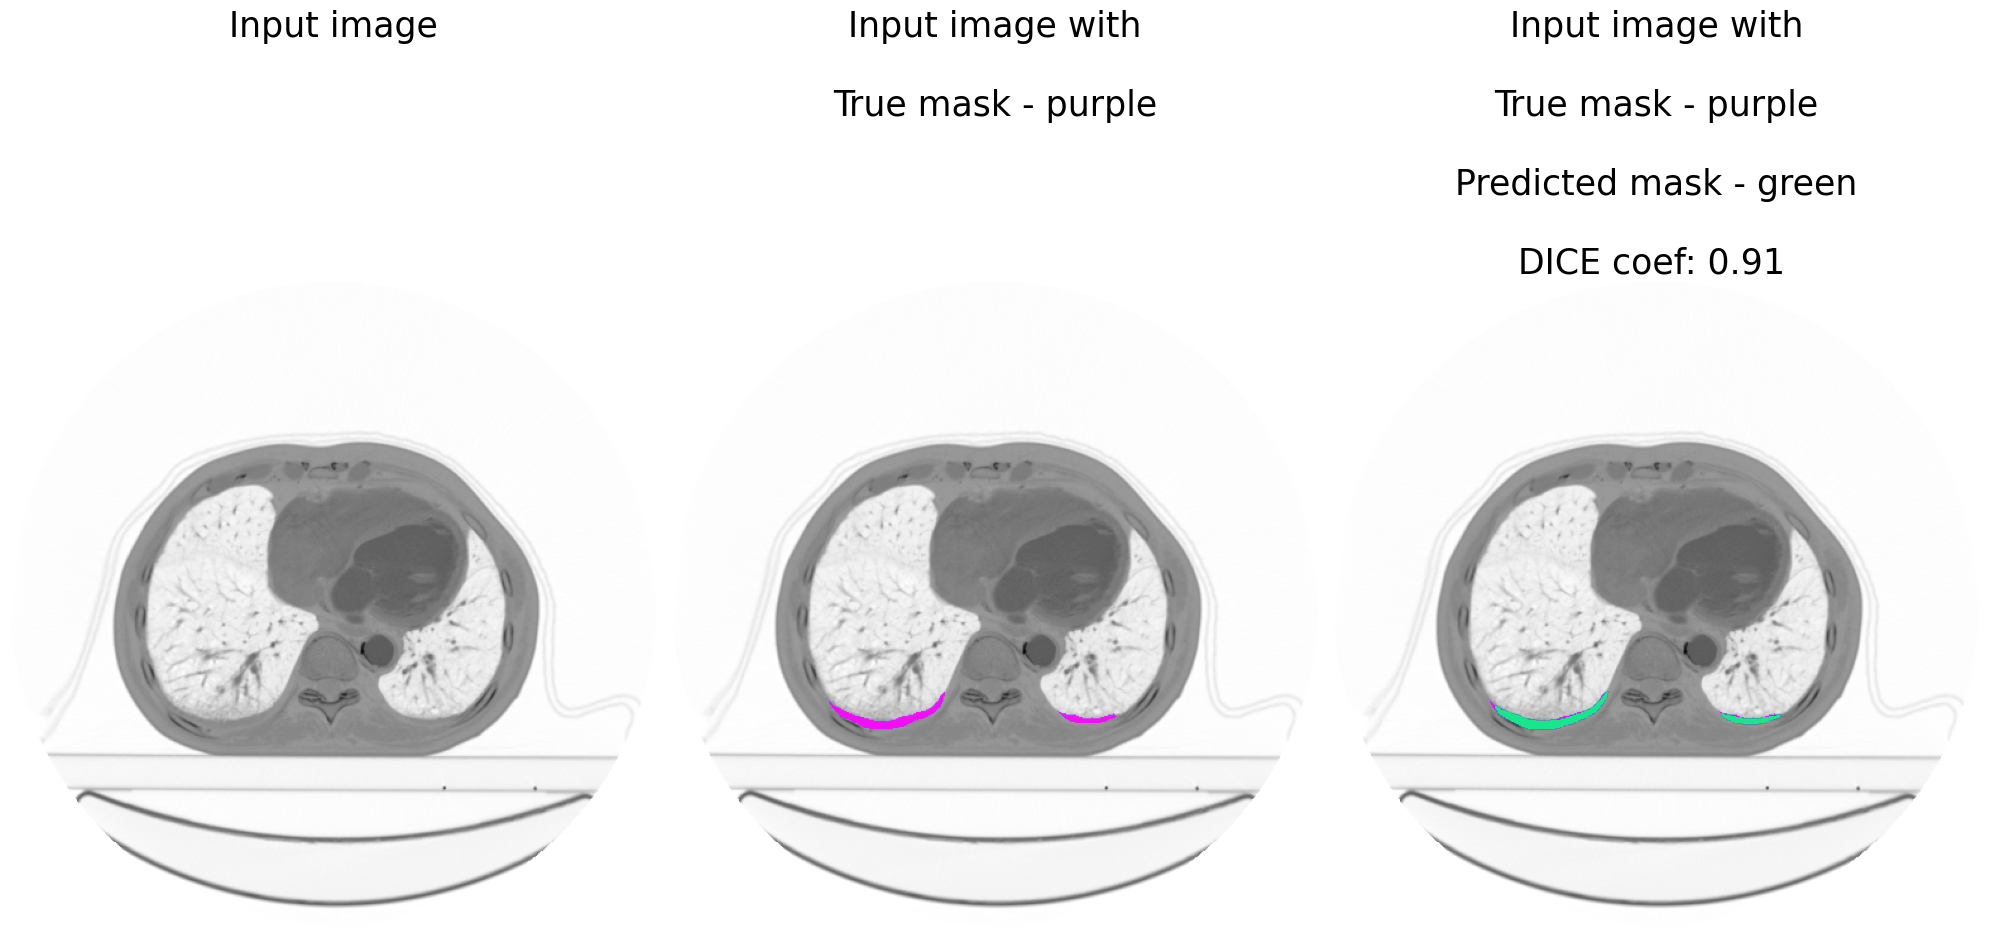

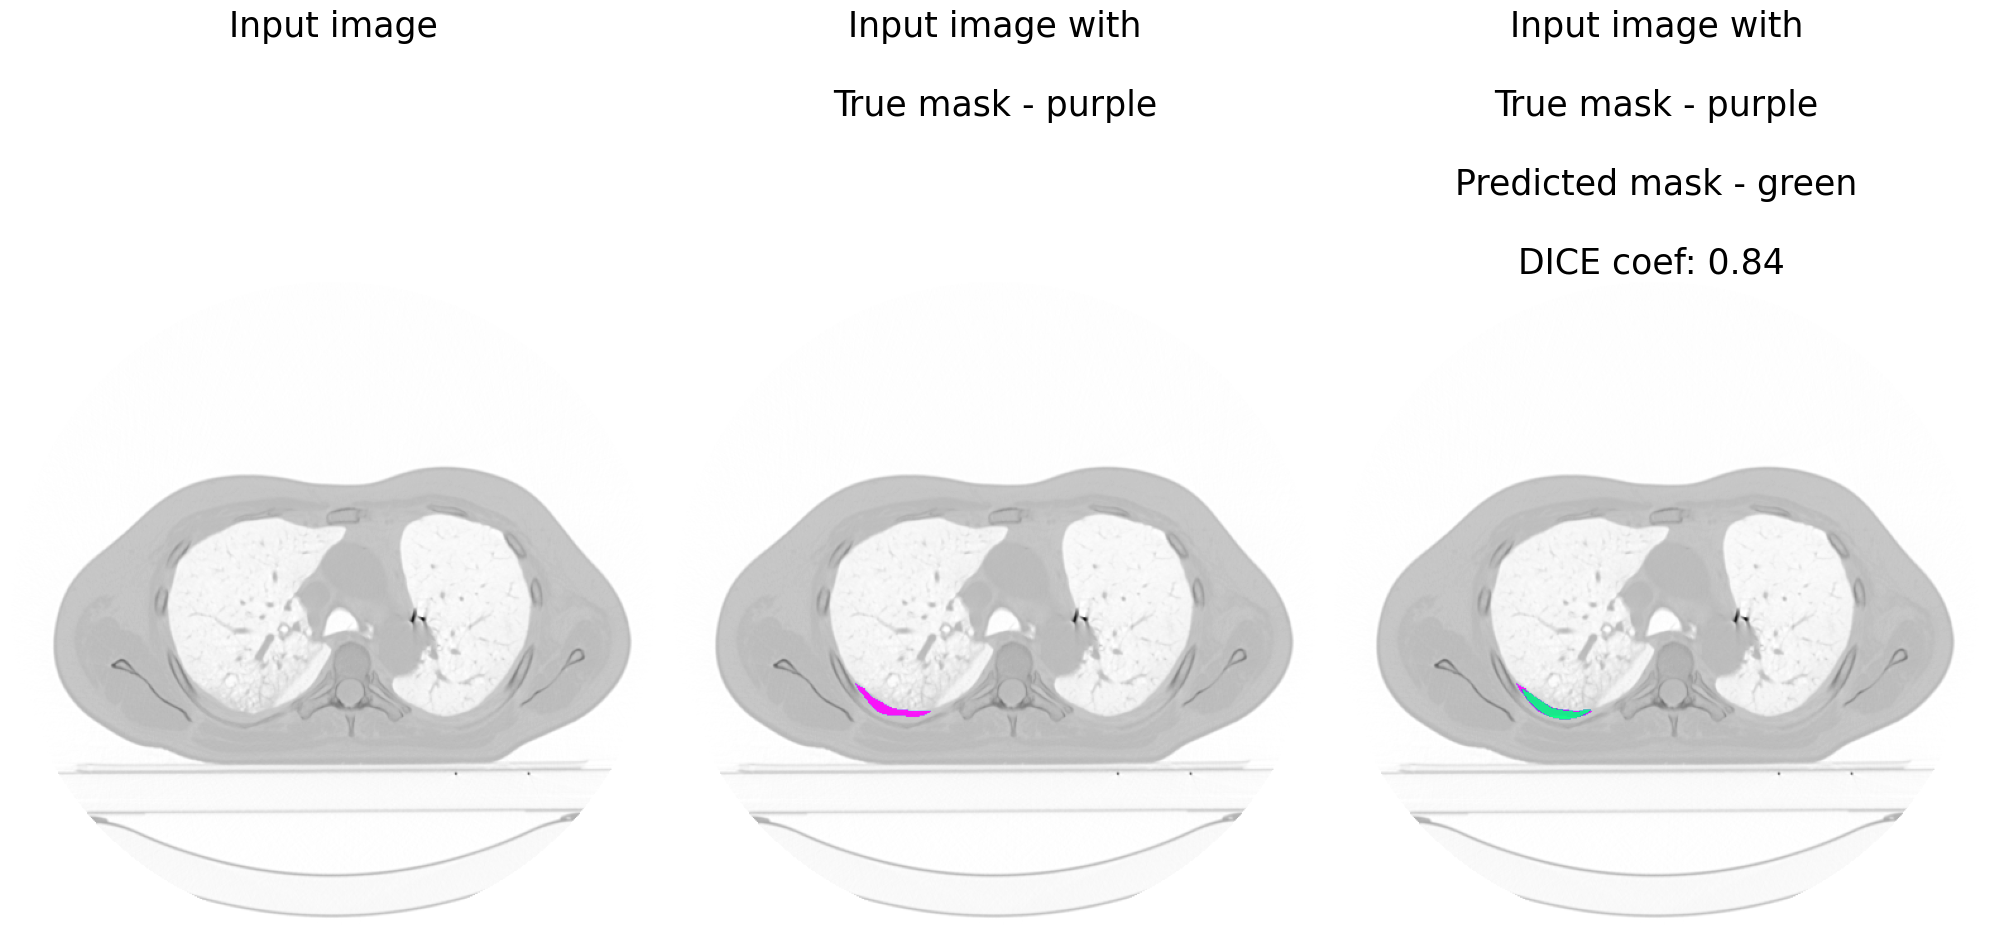

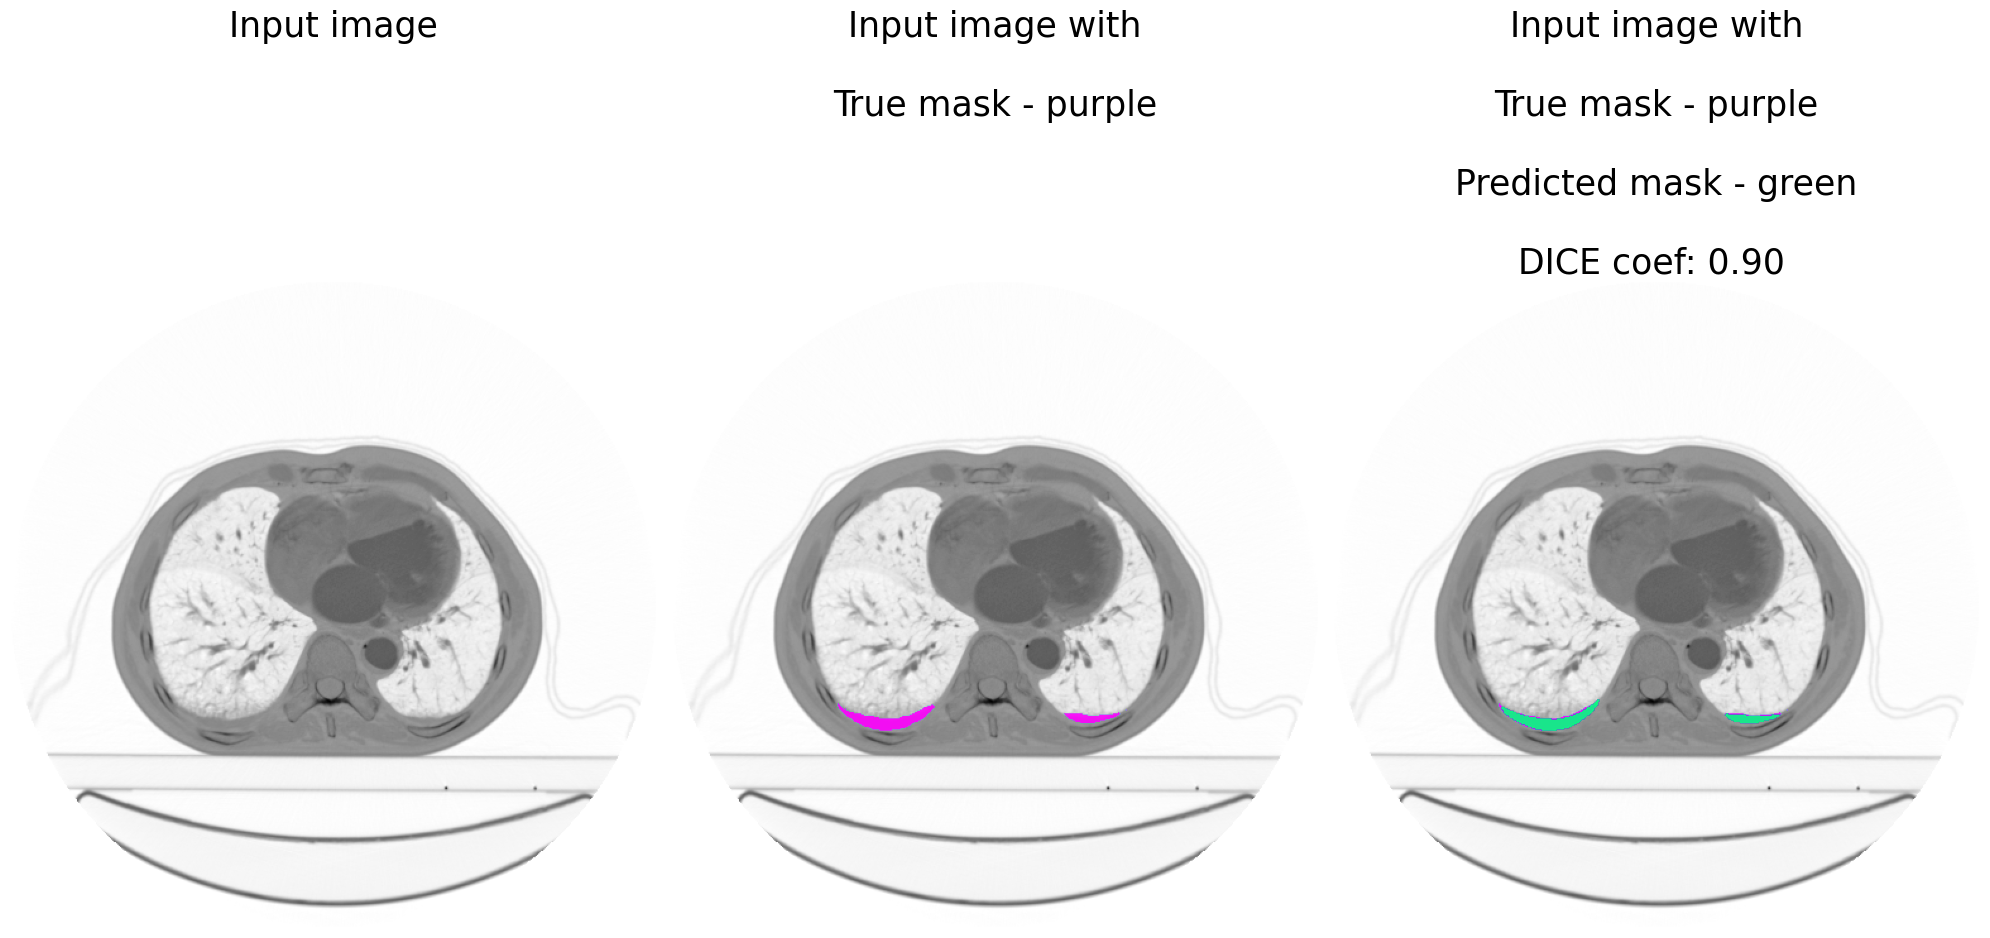

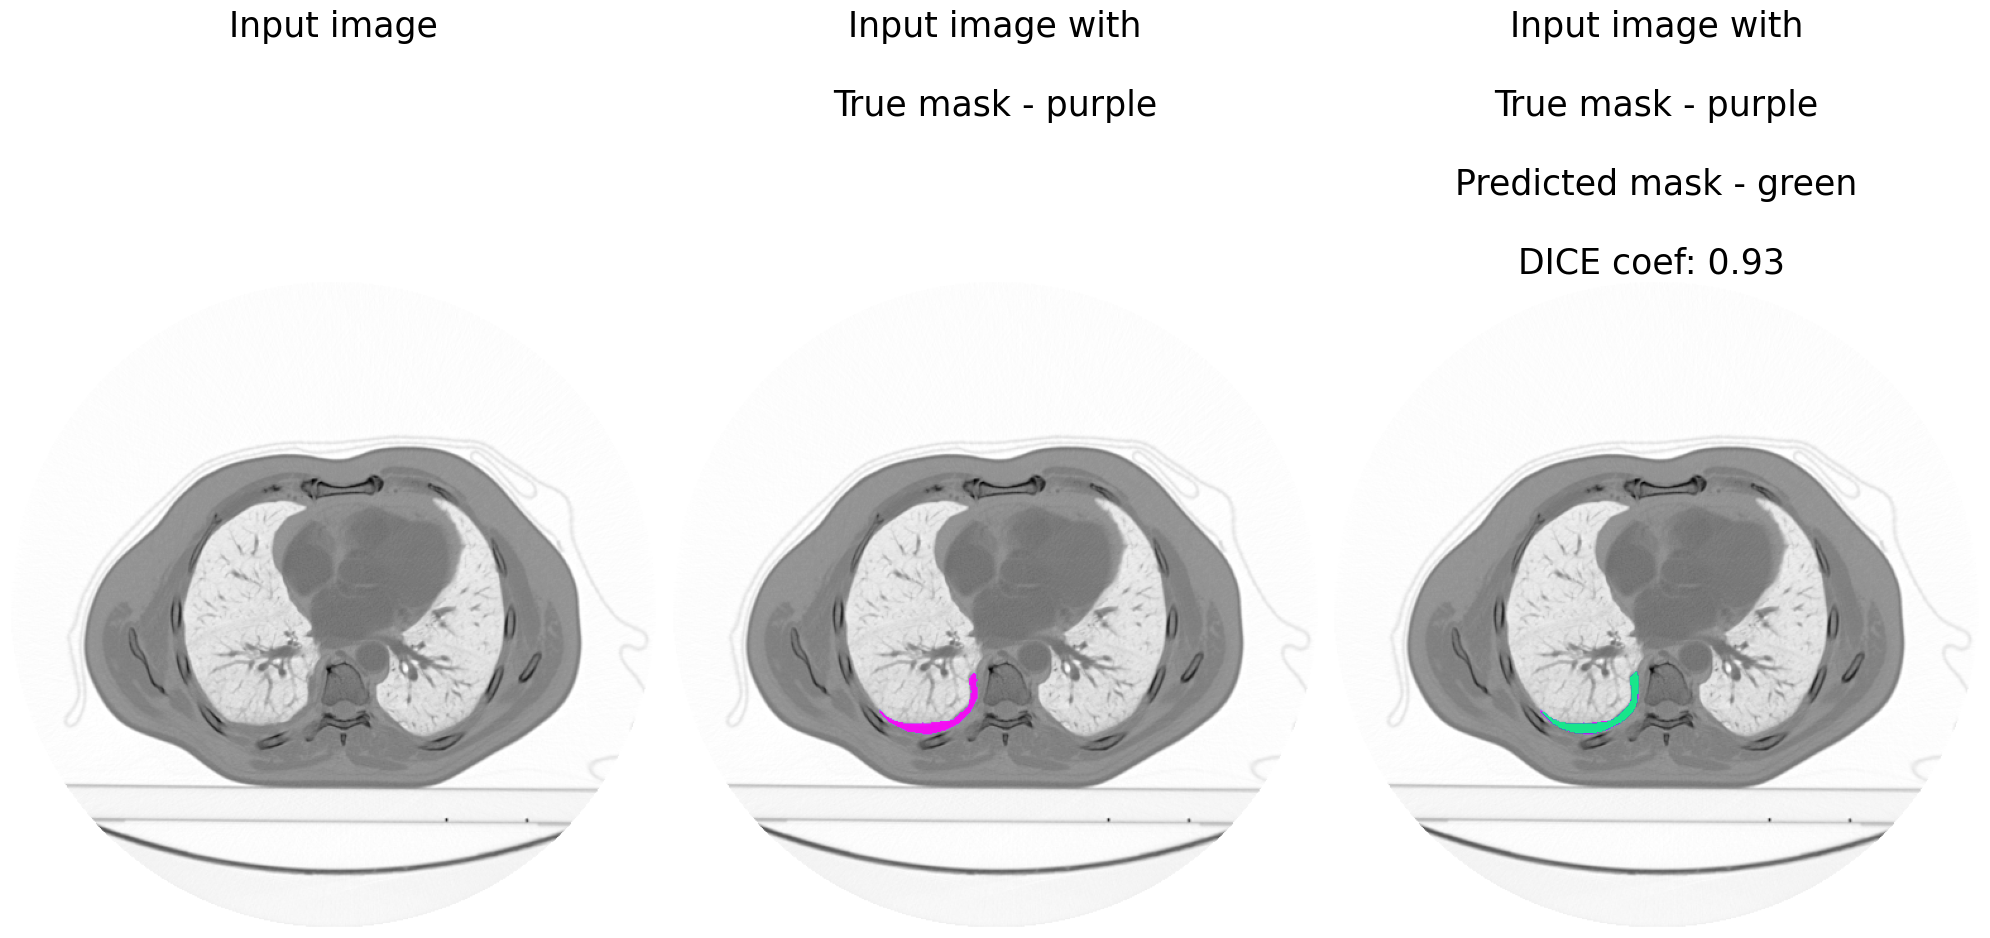

In [166]:
with torch.no_grad():
    net.eval()
    count = 0 
    for (image, mask) in valid_dataloader:
        if mask.sum() > 0 and count < 5:
            pred_mask_proba = net(image)

            pred_mask = (torch.sigmoid(pred_mask_proba) > config['evaluate']['threshold'])
            show_predictions(image, mask, pred_mask)
            count += 1
            